# Effects of Light Intensity on Spike Rate

Now we're going to load an even larger data set. The `ten_intensities` data set expands on the optogenetic spike train data we worked with in the previous chapter. Now we have data recorded from a neuron as it was stimulated with ten different intensities of the light that activates its receptors (550 nm green). We have 10 trials' worth of data at each intensity, so 100 trials in total. Each trial was 20 ms long, with optical stimulation starting at 5 ms and ending at 15 ms. Measuring the neuron's response across a range of intensities allows us to map out the response "profile" of the neuron in terms of the number of spikes elicited by differing intensities. 

[Watch a walk-through of this lesson on YouTube](https://youtu.be/SeE5omWkhnY)

---

## Learning Objectives
- Understand spike data in sparse format
- Select data for a specific intensity level
- Plot raster plots and PSTHs for specific intensity levels
- Plot raster plots and PSTHs for all intensity levels
- Use Matplotlib subplots to visualize multivariate data
- Format a complex Matplotlib figure with appropriate labeling and scales
- Use a combination of raster and PSTH plots to make inferences about the relationship between an experimentally-manipulated variable and spike rate and timing. 

---

## Import necessary packages

~~~python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
~~~

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Define variables for known experimental parameters

~~~python
stim_on = 4   # time stimulus turned on
stim_off = 14 # time stimulus turned off
num_trials = 10 # number of trials per intensity level
num_tp = 21     # Number of time points in each trial (0-20 ms, inclusive)
~~~

In [3]:
stim_on = 4
stim_off = 14
num_trials = 10
num_tp = 21

## Read the data

First we load the data. This data set is adapted from Nylen, E.L., and Wallisch, P.. (2017). [*Neural Data Science*](https://www.sciencedirect.com/book/9780128040430/neural-data-science). Academic Press.

~~~python
spikes = pd.read_csv('data/ten_intensities.csv')
~~~

In [4]:
spikes = pd.read_csv('data/ten_intensities.csv')


## Figure out the structure of the data

When first starting to work with a data set, you need to explore it and understand how it's structured. What variable type(s) are in it? How are different experimental conditions coded? Sometimes you know this, if you created the data, but often you only have a general idea of what's in a data file, and you need to inspect it to figure out the details. 

If we look at the `head` of the data, we can see that there are columns for intensitiy level, trial number, and spike time:

~~~python
spikes.head()
~~~

In [5]:
spikes.head()

,Intensity,Trial,SpikeTime
0,0,1,14
1,0,1,18
2,0,3,14
3,0,3,20
4,0,4,14


There is no data for Trial 2 shown, which means that no spikes occurred for Trial 2 at Intensity 0.

It can also be helpful to view a random sample of trials to get a sense of the variability in the data:

~~~python
spikes.sample(25)
~~~

We can view the shape of the matrix to see how much data we have. Recall that `.shape` is a property of a DataFrame object, not a method, so we don't put parentheses after it:

~~~python
spikes.shape
~~~

In [6]:
spikes.sample(25)

,Intensity,Trial,SpikeTime
119,7,3,6
56,5,5,18
157,8,2,10
74,6,2,17
104,7,0,12
31,3,9,17
6,0,6,13
55,5,5,14
117,7,2,17
10,1,6,13


### Data format

This data set doesn't look like the previous spike trains we saw: rather than zeros and ones, we have a column of spike times. This is called a **sparse** representation of the data, and it is a much more efficient way of representing spike trains than the way we saw in the previous lesson. This is because spikes are relatively rare, occurring only a few times at most on each trial. So if we represent the data by having a value for each time point on every trial, we have a lot of data points that are filled with zeros, and really tell us nothing. If our data only represent when the ones are, we can infer that the rest of the data points are zero, but we end up storing much less data. This makes working with the data faster, especially with very large data sets. 

In the `spikes` DataFrame, the first column encodes the intensity level:


~~~python
spikes['Intensity'].unique()
~~~

In [7]:
spikes['Intensity'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The `Trial` column encodes trial number (nested in intensity levels):

~~~python
spikes['Trial'].unique()
~~~

In [8]:
spikes['Trial'].unique()

array([1, 3, 4, 5, 6, 0, 2, 8, 9, 7])

And, as you might expect, `SpikeTimes` contains the times at which spike occurred. The order of trials is not sequential, because `.unique()` lists these values in the order it finds them in the DataFrame. As we saw above in the first few rows of the DataFrame, there were no spikes for Trial 2 at Intensity 0, so the first instance of `2` in the Trial column occurred further down.

Since we'll want to plot trials in order (e.g., for raster plots), we'll create a new variable called `trials` to hold the sorted list of trial numbers:

~~~python
trials = sorted(spikes['Trial'].unique())
~~~

In [10]:
trials = sorted(spikes['Trial'].unique())

## Visualizing the Data

### Raster plot
We'd like to visualize this larger data set using raster plots and PSTHs, as we did for the previous data. To do this, we'll need to consider how to show the different responses for each each intensity level. There are a few ways we could do this, but here we'll do it by adding more subplots, expanding on how we drew the raster plot and PSTH in the same figure in the previous page.

Here we'll build the code up in stages, first getting one plot working (a raster of one intensity level) and then adding the PSTH for that level, then plotting all the levels of intensity in different subplots, in a loop. We'll start with the highest intensity level (`9`) as our "test case" because we can expect that it will elicit the most intense responses. 

~~~python
# select just data for intensity level 9
dat = spikes[spikes['Intensity'] == 9]
~~~

In [11]:
dat = spikes[spikes['Intensity'] == 9]

The code below is very similar to what we used in the previous lesson, except that before we had to convert the `1`s in the data to spike times, but here the data are already in that format, so we just need to select the data for a particular trial each time through the loop:

~~~python
fig, ax = plt.subplots()

# Shade time when stimulus was on
ax.axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')

# Draw the raster one trial at a time
for trial in trials:
    # get spike times for this trial
    spike_times = dat[dat['Trial'] == trial]['SpikeTime']
    # Draw the raster
    ax.vlines(spike_times, 
              trial - 0.4, trial + 0.4)

plt.show()
~~~

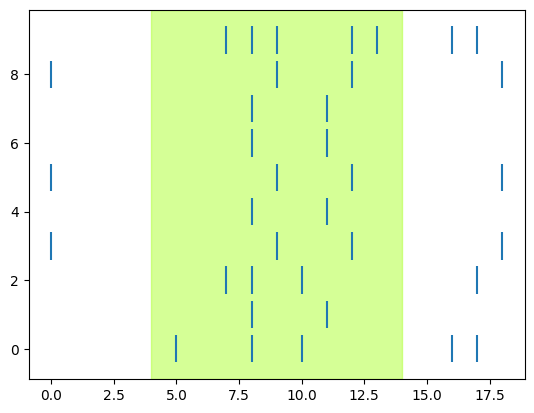

In [13]:
fig, ax = plt.subplots()

ax.axvspan(stim_on, stim_off, alpha= 0.5, color='greenyellow')

for trial in trials:
    spike_times = dat[dat['Trial'] == trial]['SpikeTime']
    ax.vlines(spike_times, trial - 0.4, trial + 0.4)

plt.show()

We can see right away that there does seem to be a relationship between stimulation and spiking, since there are more ticks during the "on" (shaded) time than before it.

### PSTH 

Now we can draw a PSTH for this intensity level. We're going to draw this differently from before, because in the previous lesson we could sum the number of spikes in each time bin. Since our data here are represented as spike times, it's easiest to use the `ax.hist()` function to count the number of times each time point is found in the data, for this particular intensity level. For the PSTH, we want a bin for every time point, so we use a combination of two kwargs to force this (because otherwise, the histogram range will only include the minimum and maximum times at which spikes occur for this intensity level, which could potentially not include the earliest and/or latest time points in the trial. The `bins` kwarg is used to set the number of bins equal to the number of time points, and the `range` kwarg tell Matplotlib to space those bins evenly from 0 to the end of the trial.

~~~python
fig, ax = plt.subplots()

# Shade time when stimulus was on
plt.axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')

ax.hist(dat['SpikeTime'], bins=range(0, num_tp, 1))

plt.show()
~~~

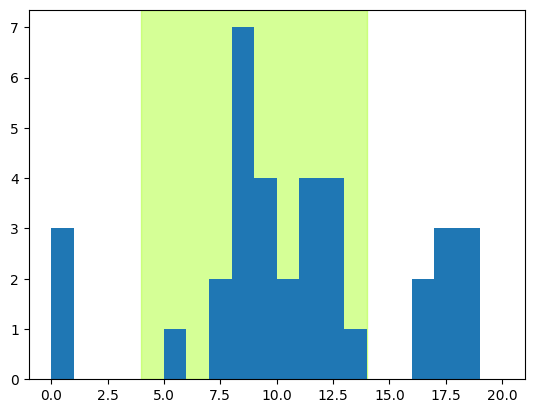

In [17]:
fig, ax= plt.subplots()

plt.axvspan(stim_on, stim_off, alpha= 0.5, color='greenyellow')

ax.hist(dat['SpikeTime'], bins= range(0, num_tp, 1))

plt.show()


### Combine raster and PSTH

Next we combined the raster and PSTH in one figure. Ultimately we want to show all intensity levels in one figure, so as a layout it will work better to have the raster and PSTH side-by-side in one row, rather than one above the other as in the previous lesson:

~~~python
# here we hard-code the figure dimensions (x, y) to control the way the plot looks
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Shade time when stimulus was on
axs[0].axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')

# select just data for intensity level 9
dat = spikes[spikes['Intensity'] == 9]

# Draw the raster one trial at a time
for trial in trials:
    # get spike times for this trial
    spike_times = dat[dat['Trial'] == trial]['SpikeTime']
    # Draw the raster
    axs[0].vlines(spike_times, 
              trial - 0.4, trial + 0.4)

    
# Shade time when stimulus was on
axs[1].axvspan(stim_on, stim_off, alpha=0.5, color='greenyellow')
axs[1].hist(dat['SpikeTime'], bins=range(0, num_tp, 1))

plt.show()
~~~

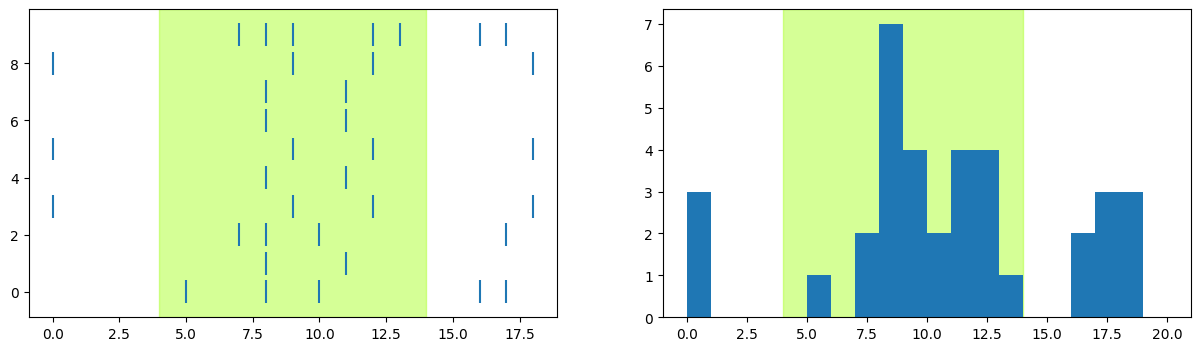

In [19]:
fig, axs = plt.subplots(1, 2, figsize=[15,4])

axs[0].axvspan(stim_on, stim_off, alpha= 0.5, color='greenyellow')

#selectively choosing the data at intensity level 9
dat = spikes[spikes['Intensity'] == 9]

for trial in trials:
    spike_times = dat[dat['Trial'] == trial]['SpikeTime']
    axs[0].vlines(spike_times, trial - 0.4, trial + 0.4)

axs[1].axvspan(stim_on, stim_off, alpha= 0.5, color='greenyellow')
axs[1].hist(dat['SpikeTime'], bins= range(0, num_tp, 1))

plt.show()

### Plotting all intensity levels

Now we can embed the plot commands above into a loop through all intensity levels. 

First, for convenience we'll create a list of intensity levels, and sort them so that they plot in a logical order (lowest to highest intensity):

~~~python
int_levels = sorted(spikes['Intensity'].unique())
~~~

We'll plot each raster and PSTH as a row, in a figure with 10 rows (intensity levels) and 2 columns of subplots. 

Note that we make use of the intensity levels not just for looping through the data, but also specify rows of subplots, and the intensity of the shading that shows when the stimulus was on. 

~~~python
# Set the number of subplot rows based on number of intensity levels in data
# Also specify the figure dimensions since it will need to be a big figure
fig, axs = plt.subplots(len(int_levels), 2, figsize=[12, 12])

for i in int_levels:
    
    ## Raster plot
    # select just data for current intensity level
    # this is convenient since we'll refer to this subset of data a few times below
    dat = spikes[spikes['Intensity'] == i]

    # Draw the raster one trial at a time
    for trial in trials:
        # get spike times for this trial
        spike_times = dat[dat['Trial'] == trial]['SpikeTime']
        # Draw the raster
        axs[i, 0].vlines(spike_times, 
                         trial - 0.4, trial + 0.4)

    # Shade time when stimulus was on
    axs[i, 0].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1,       # Base intensity of shading (alpha) on intensity level
                      color='greenyellow')

    ## PSTH
    # Shade time when stimulus was on
    axs[i, 1].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1, 
                      color='greenyellow')
    
    axs[i, 1].hist(dat['SpikeTime'], bins=range(0, num_tp, 1))

plt.tight_layout()
plt.show()
~~~

### Scale the *x* axes

You may note that the plot above looks wrong — the "stimulus on" shading doesn't line up for all the plots! This is because by default, Matplotlib scales each subplot's axes independently. For the low intensity levels, there are few spikes, and so if you look at the units on the *x* axes, they are quite variable. 

We can fix this by adding a `sharex=True` kwarg to the `plt.subplots()` call, which forces all the subplots to share the same *x* axis range. Since the histograms are already set to range from 0-21 ms, the raster plots will "inherit" the same range due to `sharex=True`. We add one further line, using `.set_xticks()` to specify the spacing of the tickmarks on the *x* axis to 2 ms:

~~~python
fig, axs = plt.subplots(len(int_levels), 2, figsize=[12, 12], sharex=True)

for i in int_levels:
    
    ## Raster plot
    # select just data for current intensity level
    # this is convenient since we'll refer to this subset of data a few times below
    dat = spikes[spikes['Intensity'] == i]

    # Draw the raster one trial at a time
    for trial in trials:
        # get spike times for this trial
        spike_times = dat[dat['Trial'] == trial]['SpikeTime']
        # Draw the raster
        axs[i, 0].vlines(spike_times, 
                         trial - 0.4, trial + 0.4)
    # Shade time when stimulus was on
    axs[i, 0].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1,       # Base intensity of shading (alpha) on intensity level
                      color='greenyellow')

    ## PSTH
    # Shade time when stimulus was on
    axs[i, 1].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1, 
                      color='greenyellow')
    
    axs[i, 1].hist(dat['SpikeTime'], bins=range(0, num_tp, 1))

    # Set the x tickmarks to every 2 ms
    axs[i, 1].set_xticks(range(0, num_tp + 1, 2))
    
plt.tight_layout()
plt.show()
~~~

### Scale the *y* axes

Although there is also a `sharey` kwarg for the *y* axis, this isn't appropriate for the current figure because the raster and PSTH plots necessarily will have different scales. The rasters are already on the same scale, since there were 10 trials at each intensity level. However, note that the *y* scales for the PSTHs are all different, which makes it very hard to compare between different intensity levels. 

There are (at least) two different ways we could do this: we could normalize the histograms (making the *y* axis the proportion of total spikes in each bin), or we could simply scale them all to the maximum number of spikes in any bin, across the entire data set. 

In this case, the latter option makes more sense. We want to compare the amount of spiking activity between different intensity levels, so we want to compare "apples to apples" by using the absolute number of spikes in each bin, rather than the proportion of spikes in each bin, at a particular intensity level. 

The way we figure out what the maximum value on the *y* axis should be, is by using an [accumulator variable](../3-python/for_loops). We initialize `y_max` before we start the plotting loop, and then as we plot the data for each intensity level we compare the upper limit of the *y* axis for the current intensity against the current value of `y_max`, and update `y_max` if the current value is larger. By the time we have looped through all intensity levels, `y_max` will contain the largest number of spikes found in the data set.

~~~python
# set the number of subplot rows based on number of intensity levels in data
# specify the figure dimensions since it will need to be a big figure
fig, axs = plt.subplots(len(int_levels), 2, figsize=[12, 12], sharex=True)

y_max = 0 # Accumulator variable

for i in int_levels:
    
    ## Raster plot
    # select just data for current intensity level
    # this is convenient since we'll refer to this subset of data a few times below
    dat = spikes[spikes['Intensity'] == i]

    # Draw the raster one trial at a time
    for trial in trials:
        # get spike times for this trial
        spike_times = dat[dat['Trial'] == trial]['SpikeTime']
        # Draw the raster
        axs[i, 0].vlines(spike_times, 
                         trial - 0.4, trial + 0.4)

    # Shade time when stimulus was on
    axs[i, 0].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1,       # Base intensity of shading (alpha) on intensity level
                      color='greenyellow')

    ## PSTH
    # Shade time when stimulus was on
    axs[i, 1].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1, 
                      color='greenyellow')
    
    # Plot histogram
    axs[i, 1].hist(dat['SpikeTime'], bins=range(0, num_tp, 1))

    # Set the x tickmarks to every 2 ms
    axs[i, 1].set_xticks(range(0, num_tp + 1, 2))
    
    # find y max of current plot
    cur_min, cur_max = axs[i, 1].get_ylim()
    
    # update y_max if necessary
    if cur_max > y_max:
        y_max = cur_max
        
for a in int_levels:
    axs[a, 1].set_ylim(0, y_max)
    
plt.tight_layout()
plt.show()
~~~

Now the PSTHs more clearly show us that the low intensity levels elicited very few spikes, while the higher intensity levels elicited a lot more.

Finally, we can properly annotate (label) the graph for easy interpretation, adding things like axis labels and titles. We'll also make sure the axes of all the plots are the same:

~~~python
# set the number of subplot rows based on number of intensity levels in data
# specify the figure dimensions since it will need to be a big figure
fig, axs = plt.subplots(len(int_levels), 2, figsize=[12, 12], sharex=True)

y_max = 0 # Accumulator variable

for i in int_levels:
    ## Raster plot
    # select just data for current intensity level
    # this is convenient since we'll refer to this subset of data a few times below
    dat = spikes[spikes['Intensity'] == i]

    # Draw the raster one trial at a time
    for trial in trials:
        # get spike times for this trial
        spike_times = dat[dat['Trial'] == trial]['SpikeTime']
        # Draw the raster
        axs[i, 0].vlines(spike_times, 
                         trial - 0.4, trial + 0.4)

    # Shade time when stimulus was on
    axs[i, 0].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1,       # Base intensity of shading (alpha) on intensity level
                      color='greenyellow')

    # Label the y axis with intensity level
    axs[i, 0].set_ylabel('Intensity  ' + str(i))
    
    # place title only above the first row of plots:
    if i == 0:
        axs[i, 0].set_title('Raster Plot for each intensity', fontsize=10)
 

    ## PSTH
    # Shade time when stimulus was on
    axs[i, 1].axvspan(stim_on, stim_off, 
                      alpha= i / 10 + .1, 
                      color='greenyellow')
    
    # Plot histogram
    axs[i, 1].hist(dat['SpikeTime'], bins=range(0, num_tp, 1))

    # Set the x tickmarks to every 2 ms
    axs[i, 1].set_xticks(range(0, num_tp + 1, 2))
    
    # Label the y axis 
    axs[i, 1].set_ylabel('Num. Spikes')

    # find y max of current plot
    cur_min, cur_max = axs[i, 1].get_ylim()
    
    # update y_max if necessary
    if cur_max > y_max:
        y_max = cur_max
        
    # place title only above the first row of plots:
    if i == 0:
        axs[i, 1].set_title('PSTH for each intensity', fontsize=10)
        
    # Place x label only below bottom row of plots:    
    if i == max(int_levels):
        axs[i, 1].set_xlabel('Time (ms)')
        axs[i, 0].set_xlabel('Time (ms)')

# Having plotted all intensity levels, re-scale y axis to the max we found
# Also apply the same scale to all rasters
for a in int_levels:
    axs[a, 0].set_ylim(0, num_trials)
    axs[a, 1].set_ylim(0, y_max)
    
# Add an overall figure title
fig.suptitle('Effects of 550 nm light intensity on spike rate of neuron')
    
plt.tight_layout()
plt.show()
~~~

## Interpreting the data

Now that we have a nice visualization, we can use it to make sense of the data. Take some time to look at the figure above and think about what it shows you, about the relationship between light intensity and the activity of the neuron, then read on below.

It is clear from the figure that more intense light stimulation elicits a stronger response from the neuron. Furthermore, it doesn't look like there is a *linear* relationship between intensity and neuronal activity. If the relationship was linear, we would see a steady increase in spiking with increasing intensity level. Instead, it looks like the light elicits very little response at levels 0–2, a weak response at levels 3–5, and a stronger response at levels 6–9. So it may be that the neuron has a *threshold* level of light intensity, below which it doesn't respond, and above which it does respond. From levels 3 to 8, spiking intensity seems to increase with light intensity, however at level 9 the peak number of spikes is lower than for levels 7 or 8. 

This relationship also appears to involve both the intensity of the neuron's response (spike rate), and its timing. As intensity increases, especially from level 3 upwards, the time at which spiking activity is evident relative to the onset of the light stimulation seems to get earlier, as does the time at which peak spiking occurs. So it seems that the latency to first spike property we mentioned in the previous lesson is influenced by light intensity.

Finally, the neuron seems. to show offset as well as onset effects. That is, at least at the highest intensity levels (7–9) there is a clear decrease in spiking towards the end of the stimulation period, followed by a brief increase in spiking after the light turns off. 

---